In [1]:
import tiledb
import pandas as pd
import plotnine
from pandas import DataFrame

from backend.wmg.data.ontology_labels import ontology_term_label, gene_term_label
from pronto import Ontology
import pygraphviz as pgv
from collections import defaultdict
from typing import Dict, List, Any, Iterable
import json
import requests
import os
import yaml
from collections import OrderedDict

from backend.wmg.data.snapshot import (
    CELL_TYPE_ORDERINGS_FILENAME,
    EXPRESSION_SUMMARY_CUBE_NAME,
    PRIMARY_FILTER_DIMENSIONS_FILENAME,
)

from math import isnan



config = tiledb.Config()
config["vfs.s3.scheme"] = "https" 
config["vfs.s3.region"] = "us-west-2"
# config["vfs.s3.endpoint_override"] = ""
# config["vfs.s3.use_virtual_addressing"] = True
tdb_ctx = tiledb.Ctx(config=config)

Import cell counts per cell type

In [2]:
cell_counts_db = tiledb.open("s3://cellxgene-wmg-prod/1651599970/cell_counts/", ctx=tdb_ctx)

In [3]:
cell_counts = cell_counts_db.query(attrs=["cell_type_ontology_term_id", "n_cells"]).df[:,:]
cell_counts = cell_counts[~cell_counts.tissue_ontology_term_id.str.contains("cell culture")]
distinct_tissues_cell_types = cell_counts.groupby(
    ["tissue_ontology_term_id", "cell_type_ontology_term_id", "organism_ontology_term_id"], as_index=False
).sum()

distinct_tissues_cell_types = distinct_tissues_cell_types.loc[distinct_tissues_cell_types["organism_ontology_term_id"].isin(["NCBITaxon:9606", "NCBITaxon:10090"])]
distinct_tissues_cell_types


,tissue_ontology_term_id,cell_type_ontology_term_id,organism_ontology_term_id,n_cells
0,UBERON:0000016,CL:0000084,NCBITaxon:9606,22
1,UBERON:0000016,CL:0000097,NCBITaxon:9606,1
2,UBERON:0000016,CL:0000115,NCBITaxon:9606,146
3,UBERON:0000016,CL:0000169,NCBITaxon:9606,2
4,UBERON:0000016,CL:0000171,NCBITaxon:9606,3
...,...,...,...,...
1950,UBERON:8410026,CL:1000296,NCBITaxon:9606,1846
1951,UBERON:8410026,CL:1000304,NCBITaxon:9606,135
1952,UBERON:8410026,CL:1000305,NCBITaxon:9606,238
1953,UBERON:8410026,CL:1000487,NCBITaxon:9606,78


In [4]:
counts_per_celltype = []
limits = range(1,30)

for organism in distinct_tissues_cell_types["organism_ontology_term_id"].drop_duplicates():
    current = distinct_tissues_cell_types[distinct_tissues_cell_types["organism_ontology_term_id"] == organism]
    for count in limits:
        counts_per_celltype.append([organism, count,sum(current["n_cells"] < count), len(current)])
    
counts_per_celltype = DataFrame(counts_per_celltype, columns=["organism_ontology_term_id", "n_cells", "Count", "Count_total"])
counts_per_celltype["Frequency"] = counts_per_celltype["Count"] / counts_per_celltype["Count_total"]


In [5]:
counts_per_celltype

,organism_ontology_term_id,n_cells,Count,Count_total,Frequency
0,NCBITaxon:9606,1,0,1667,0.000000
1,NCBITaxon:9606,2,30,1667,0.017996
2,NCBITaxon:9606,3,56,1667,0.033593
3,NCBITaxon:9606,4,88,1667,0.052789
4,NCBITaxon:9606,5,111,1667,0.066587
5,NCBITaxon:9606,6,129,1667,0.077385
6,NCBITaxon:9606,7,141,1667,0.084583
7,NCBITaxon:9606,8,150,1667,0.089982
8,NCBITaxon:9606,9,160,1667,0.095981
9,NCBITaxon:9606,10,174,1667,0.104379


/Users/pgarcianieto/opt/miniconda3/envs/cellxgene_notebooks/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


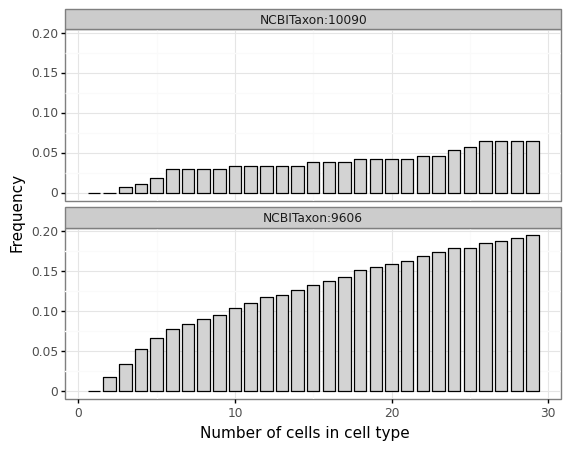

<ggplot: (8776249074387)>

In [8]:
(
    plotnine.ggplot(counts_per_celltype)
    + plotnine.aes(x = "n_cells", y="Frequency") 
    + plotnine.geom_bar(fill = "lightgrey", color = "black", width = 0.8, stat="identity")
    + plotnine.themes.theme_bw()
    + plotnine.facets.facet_wrap("~organism_ontology_term_id", ncol=1)
    + plotnine.labels.xlab("Number of cells in cell type")
)

/Users/pgarcianieto/opt/miniconda3/envs/cellxgene_notebooks/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


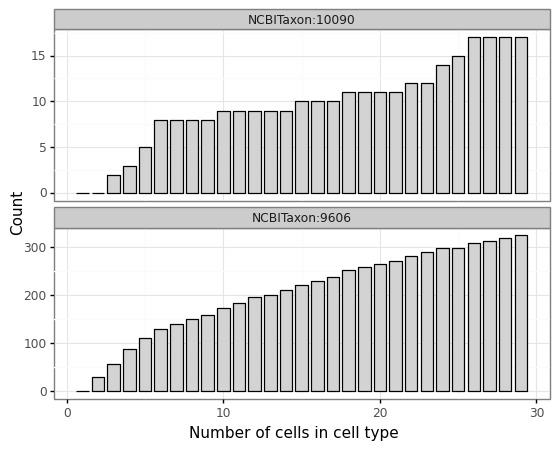

<ggplot: (8776249484213)>

In [7]:
(
    plotnine.ggplot(counts_per_celltype)
    + plotnine.aes(x = "n_cells", y="Count") 
    + plotnine.geom_bar(fill = "lightgrey", color = "black", width = 0.8, stat="identity")
    + plotnine.themes.theme_bw()
    + plotnine.facets.facet_wrap("~organism_ontology_term_id", ncol=1, scales="free_y")
    + plotnine.labels.xlab("Number of cells in cell type")
)